In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import cv2
import glob
import re
from matplotlib import pyplot as plt
import time as t
print "OpenCV version: {}".format(cv2.__version__)
# https://wiki.python.org/moin/PythonSpeed/PerformanceTips

OpenCV version: 2.4.11


In [2]:
img_w = 640
img_h = 480
RESOLUTION = (img_w, img_h)
grid_w = 8
grid_h = 6
GRID_SIZE = (grid_w, grid_h)
sq_size = 3.3 # cm
crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((grid_w*grid_h,3), np.float32)
objp[:,:2] = np.mgrid[0:grid_w,0:grid_h].T.reshape(-1,2) * sq_size

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [4]:
images = glob.glob('stereo-example2/img-calib/*.jpg')
goodImages = []

objpoints = []
imgpoints1 = []
imgpoints2 = []

for fname in images:
    imgR = cv2.imread(fname)
    imgL = imgR[:, 0:img_w]
    imgR = imgR[:, img_w:]
    
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    retL, cornersL = cv2.findChessboardCorners(grayL, GRID_SIZE)
    retR, cornersR = cv2.findChessboardCorners(grayR, GRID_SIZE)
        
    if retL is True and retR is True:
        objpoints.append(objp)
        cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), crit)
        cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), crit)
        imgpoints1.append(cornersL)
        imgpoints2.append(cornersR)
        cv2.drawChessboardCorners(imgL, GRID_SIZE, cornersL, retL)
        cv2.drawChessboardCorners(imgR, GRID_SIZE, cornersR, retR)
        goodImages.append(fname)
        
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints1, RESOLUTION)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints2, RESOLUTION)

ret, _, _, _, _, R, T, E, F  = cv2.stereoCalibrate(objpoints, imgpoints1, imgpoints2, RESOLUTION)
R1, R2, P1, P2, Q, ROI1, ROI2 = cv2.stereoRectify(mtxL, distL, mtxR, distR, RESOLUTION, R, T, flags=cv2.CALIB_ZERO_DISPARITY)

x1L, y1L, x2L, y2L = ROI1
x1R, y1R, x2R, y2R = ROI2

map1L, map2L = cv2.initUndistortRectifyMap(mtxL, distL, R1, mtxL, RESOLUTION, cv2.CV_32FC1)
map1R, map2R = cv2.initUndistortRectifyMap(mtxR, distR, R2, mtxR, RESOLUTION, cv2.CV_32FC1)

# for fname in goodImages:
    # name = re.findall(r'[\w\d\-]+\.\w+',fname)[0]
    # time = t.clock()
    # imgR = cv2.imread(fname)
    # imgL = imgR[:, 0:img_w]
    # imgR = imgR[:, img_w:]    
    # imgL = cv2.remap(imgL, map1L, map2L, cv2.INTER_CUBIC)
    # imgR = cv2.remap(imgR, map1R, map2R, cv2.INTER_CUBIC)
    # imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    # imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    # cv2.imwrite('stereo-example2/img-rectified/rectL'+name, dstL)
    # cv2.imwrite('stereo-example2/img-rectified/rectR'+name, dstR)
    # plt.subplot(1,2,1), plt.imshow(imgL, 'gray')
    # plt.subplot(1,2,2), plt.imshow(imgR, 'gray')
    # plt.show()
    # print t.clock() - time

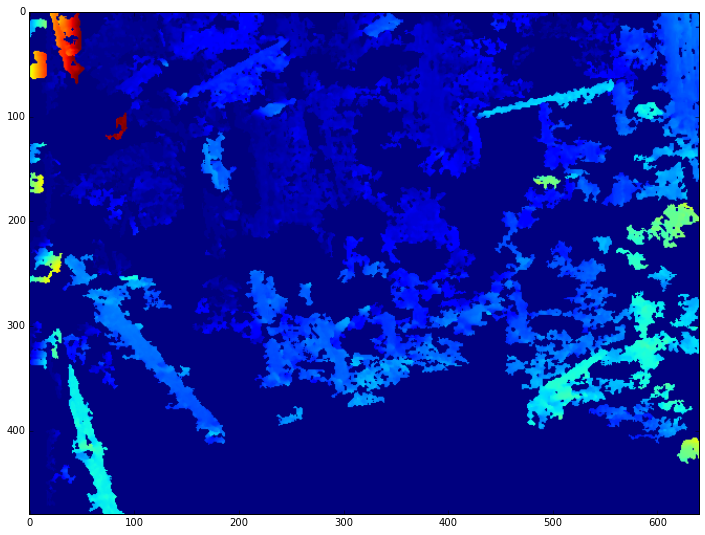

In [29]:
from IPython.html import widgets
from IPython.display import display

path = 'stereo-example2/img-stereo/'
M = img_w / 8
# P1 = 8*number_of_image_channels*SADWindowSize*SADWindowSize
# P2 = 32*number_of_image_channels*SADWindowSize*SADWindowSize

def stereoSGBM(mindisp=0, sadw=1, disp12=0, pfiltc=0, unqrat=5, spckw=0, spckr=1):
    imgR = cv2.imread(path+'scene00651.jpg')
    imgL = imgR[:, 0:img_w]
    imgR = imgR[:, img_w:]
    imgL = cv2.remap(imgL, map1L, map2L, cv2.INTER_LINEAR)
    imgR = cv2.remap(imgR, map1R, map2R, cv2.INTER_LINEAR)
    grayL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
    numdisp = M - mindisp
    stereo = cv2.StereoSGBM(mindisp, M-mindisp, sadw, 8*sadw*sadw, 32*sadw*sadw, disp12, pfiltc, unqrat, spckw, spckr)
    disparity = stereo.compute(imgL,imgR)
    plt.imshow(disparity)
    plt.show()
    # plt.subplot(2,2,1),plt.imshow(grayL, 'gray')
    # plt.subplot(2,2,2),plt.imshow(grayR, 'gray')
    # plt.subplot(2,2,3),plt.imshow(dstL, 'gray')
    # plt.subplot(2,2,4),plt.imshow(dstR, 'gray')
    # plt.show()
    
mindisp_slider = widgets.IntSliderWidget(min=0, max=M-16, step=16, value=16, description='minDisparity')
sadw_slider = widgets.IntSliderWidget(min=1, max=21, step=2, value=1, description='SADWindowSize')
disp12_slider = widgets.IntSliderWidget(min=-1, max=5, step=1, value=1, description='disp12MaxDiff')
pfiltc_slider = widgets.IntSliderWidget(min=0, max=63, step=1, value=54, description='preFilterCap')
unqrat_slider = widgets.IntSliderWidget(min=5, max=15, step=1, value=145, description='uniquenessRatio')
spckw_slider = widgets.IntSliderWidget(min=50, max=200, step=1, value=160, description='speckleWindowSize')
spckr_slider = widgets.IntSliderWidget(min=1, max=2, step=1, value=2, description='speckleRange')

w = widgets.interactive(stereoSGBM, mindisp=mindisp_slider, sadw=sadw_slider, disp12=disp12_slider,
                        pfiltc=pfiltc_slider, unqrat=unqrat_slider, spckw=spckw_slider, spckr=spckr_slider)
display(w)

In [16]:
nms = dir(cv2) # list of everything in the cv2 module
[m for m in nms if 'PRESET' in m]

['STEREO_BM_BASIC_PRESET',
 'STEREO_BM_FISH_EYE_PRESET',
 'STEREO_BM_NARROW_PRESET']

In [7]:
help(widgets.interactive)

Help on function interactive in module IPython.html.widgets.interaction:

interactive(__interact_f, **kwargs)
    Builds a group of interactive widgets tied to a function and places the
    group into a Box container.
    
    Returns
    -------
    container : a Box instance containing multiple widgets
    
    Parameters
    ----------
    __interact_f : function
        The function to which the interactive widgets are tied. The `**kwargs`
        should match the function signature.
    **kwargs : various, optional
        An interactive widget is created for each keyword argument that is a
        valid widget abbreviation.

